<h1><b>Problem Statement </b></h1>

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


<h3><b> Importing Necessary Libraries</b> </h3>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense
import pathlib
import os
import shutil

In [2]:
from google.colab import drive

<h3><b> Reading Train and Test Data</b> </h3>

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
drive.mount('/content/drive')
data_dir_train = pathlib.Path("/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
### Deleting previous generated output folders so that train and test data should not contain old output images.

def delete_output_directories(base_path):
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(base_path):
        # Check if 'output' is in the current directory's name
        if 'output' in dirnames:
            output_dir = os.path.join(dirpath, 'output')
            try:
                # Remove the directory and all its contents
                shutil.rmtree(output_dir)
                print(f"Deleted: {output_dir}")
            except Exception as e:
                print(f"Error deleting {output_dir}: {e}")

# Specify the base path
base_path = "/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

# Delete all output directories
delete_output_directories(base_path)
data_dir_train_aug = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
delete_output_directories(data_dir_train_aug)


Deleted: /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output
Deleted: /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output
Deleted: /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output
Deleted: /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output


<h3><b> Understanding Data</b> </h3>

In [5]:
import os
import pandas as pd

def count_files_in_class_subdirectories(base_dir):
    """
    This function takes a directory path containing class subdirectories and counts the number of files
    in each class subdirectory. It returns a DataFrame with class names and their corresponding file counts.

    Args:
    base_dir (str): The path to the base directory containing class subdirectories.

    Returns:
    pd.DataFrame: DataFrame containing class names and their file counts.
    """
    # Initialize an empty list to store class names and their corresponding file counts
    class_file_counts = []

    # Iterate over each subdirectory in the base directory
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)

        # Check if the path is a directory
        if os.path.isdir(class_path):
            # Count the number of files in the class directory
            file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            # Append the class name and file count to the list
            class_file_counts.append({'Class Name': class_name, 'File Count': file_count})

    # Create a DataFrame from the list and return it
    return pd.DataFrame(class_file_counts).sort_values(by=["File Count"],ascending=False)


In [6]:
# Get Count of Images for Train Dataset
base_dir = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_df_count = count_files_in_class_subdirectories(base_dir)
train_df_count


,Class Name,File Count
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


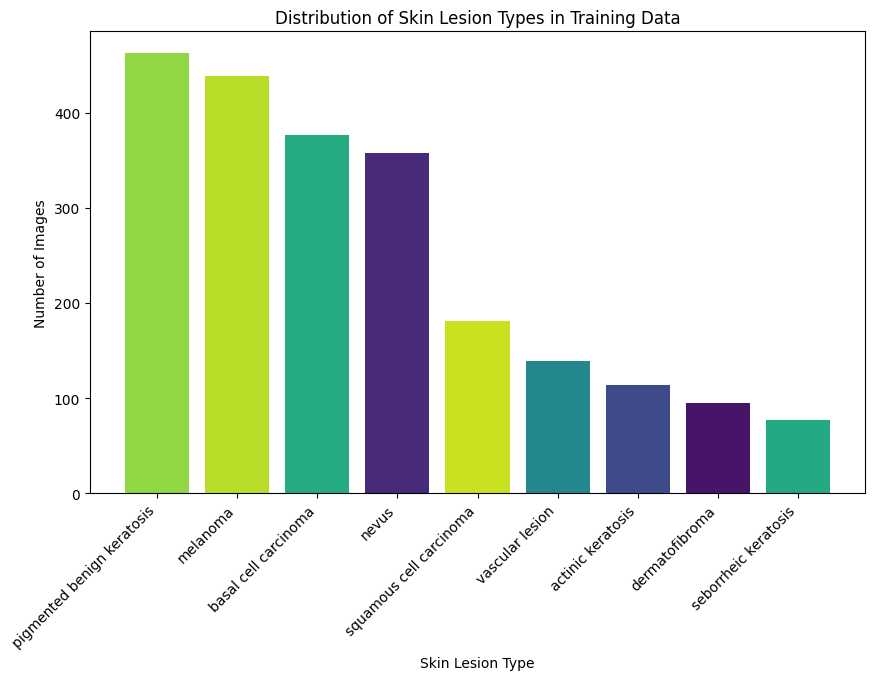

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a list of random colors
colors = np.random.rand(len(train_df_count))

plt.figure(figsize=(10, 6))

# Create a bar chart with random colors for each bar
plt.bar(train_df_count['Class Name'], train_df_count['File Count'], color=plt.cm.viridis(colors))

plt.title('Distribution of Skin Lesion Types in Training Data')
plt.xlabel('Skin Lesion Type')
plt.ylabel('Number of Images')
_ = plt.xticks(rotation=45, horizontalalignment='right')

plt.show()


In [8]:
# Get Count of Images for Test Dataset
base_dir = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
test_df_count = count_files_in_class_subdirectories(base_dir)
test_df_count


,Class Name,File Count
0,actinic keratosis,16
1,basal cell carcinoma,16
2,dermatofibroma,16
3,melanoma,16
4,nevus,16
5,pigmented benign keratosis,16
7,squamous cell carcinoma,16
6,seborrheic keratosis,3
8,vascular lesion,3


In [9]:
print("Total train images found in Train Folder:",train_df_count["File Count"].sum())

Total train images found in Train Folder: 2239


In [10]:
print("Total Test images found in Test Folder:",test_df_count["File Count"].sum())

Total Test images found in Test Folder: 118


In [11]:
img_height = 180
img_width = 180
batch_size = 32
validation_split = 0.2



<h3> <b> Create Train & Validation dataset from the train directory with a batch size of 32 </b></h3>

In [12]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<h3> <b>Data Visualization one instance from all categories. </b></h3>

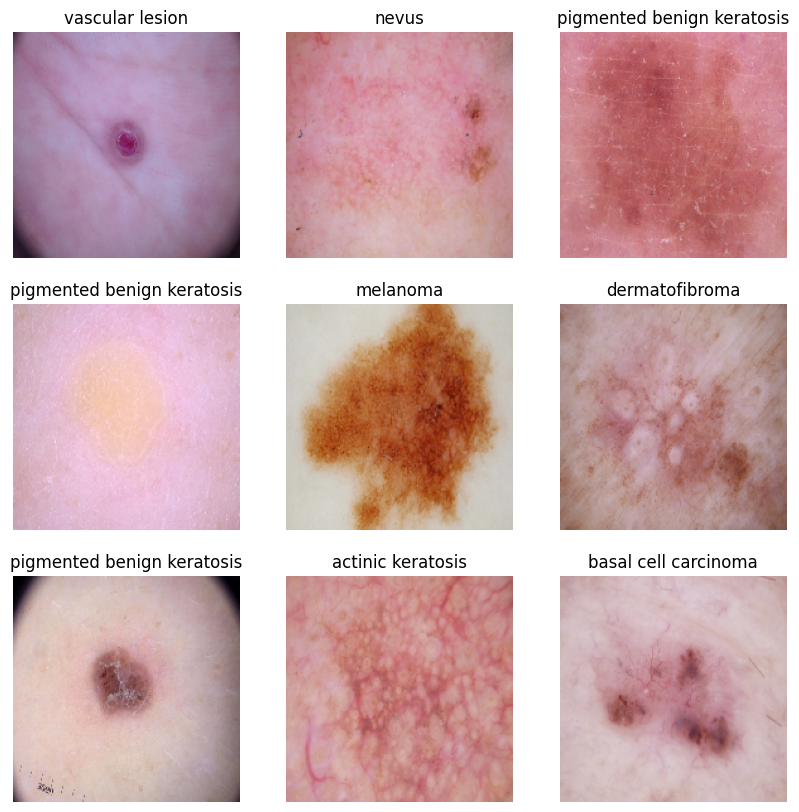

In [14]:
def visualize_images(dataset, class_names, num_images=9):
    """
    Visualizes a grid of images with their corresponding class labels.

    Args:
    dataset (tf.data.Dataset): The dataset to visualize.
    class_names (list): List of class names corresponding to the labels.
    num_images (int): Number of images to display in the grid (default is 9).
    """
    plt.figure(figsize=(10, 10))

    # Take one batch of images from the dataset
    for images, labels in dataset.take(1):
        # Display the specified number of images in a grid
        for i in range(min(num_images, len(images))):  # Ensure we don't exceed available images in the batch
            ax = plt.subplot(3, 3, i + 1)  # 3x3 grid
            plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for display
            plt.title(class_names[labels[i].numpy()])  # Get the class name using label
            plt.axis("off")  # Hide axes for better visualization

    plt.show()

# Assuming you have a separate dataset for validation or test
# You can also use the training dataset directly
class_names = train_data.class_names  # Get class names from the dataset
visualize_images(train_data, class_names)


In [15]:
total_class_names = train_data.class_names
total_class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [16]:
# Normalize pixel values to be between 0 and 1
normalization_layer = layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))



* <b>AUTOTUNE:</b>Automatically optimizes the number of data elements loaded ahead of time for better performance. <br>
* <b> cache():</b> Stores the data in memory after the first load to avoid reloading it and speed up future epochs.<br>
* <b>shuffle(1000):</b> Randomly shuffles the data, so the model sees different data orders in each epoch.  <br>
* <b>prefetch(buffer_size=AUTOTUNE):</b> Prepares the next batch of data while the current one is being processed, improving efficiency.





In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

<h4> <b> Created Common method below which will add the convolutional layer, max pooling , model compile and can be re-used later.</b><h4>

In [18]:
def build_model(data_augmentation):
    model = models.Sequential()

    if(data_augmentation):
        print("added augmentation")
        model.add(data_augmentation)

    model.add(Conv2D(16,(3,3), input_shape=(img_height,img_width,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64,(3,3), activation='relu'))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dense(9,activation='softmax'))

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

In [19]:
model = build_model(None)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107584)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,885,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,909,609 (26.36 MB)

 Trainable params: 6,909,609 (26.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
%%time
history = model.fit(train_data, validation_data= validation_data, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.1909 - loss: 2.7681 - val_accuracy: 0.3043 - val_loss: 1.9143
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3365 - loss: 1.8525 - val_accuracy: 0.4519 - val_loss: 1.6645
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4538 - loss: 1.5884 - val_accuracy: 0.5190 - val_loss: 1.4655
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4569 - loss: 1.4809 - val_accuracy: 0.3870 - val_loss: 1.6511
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5157 - loss: 1.3769 - val_accuracy: 0.5369 - val_loss: 1.3813
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4874 - loss: 1.4134 - val_accuracy: 0.4877 - val_loss: 1.5532
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5610 - loss: 1.2257 - val_accuracy: 0.5257 - val_loss: 1.4602
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6349 - loss: 1.0937 - val_accuracy: 0.5481 - 

* <b> Training Accuracy:</b> After 20 epochs, the training accuracy reaches 85%,
indicating the model has learned well from the training data.

* <b> Test Accuracy:</b> However, the test accuracy is only 54%, suggesting that the model is not generalizing well to unseen data.

* <b> Overfitting:</b> The significant gap between training and test accuracy indicates that the model has likely overfitted to the training data, meaning it has learned the noise and specific patterns in the training data that do not generalize to the test set.

* <b> Recommended:</b> To reduce overfitting, it is recommended to use data augmentation techniques, such as rotation, random flipping, and zooming. These techniques can help the model generalize better by introducing variations in the data, preventing it from memorizing the training set.

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs):
    """
    Plots training and validation accuracy and loss from the training history.

    Args:
    history: The training history object returned by model.fit().
    epochs: The number of epochs used in training.
    """
    # Extract accuracy and loss values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Define the range of epochs
    epochs_range = range(epochs)

    # Create the plots
    plt.figure(figsize=(15, 10))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Show the plots
    plt.show()


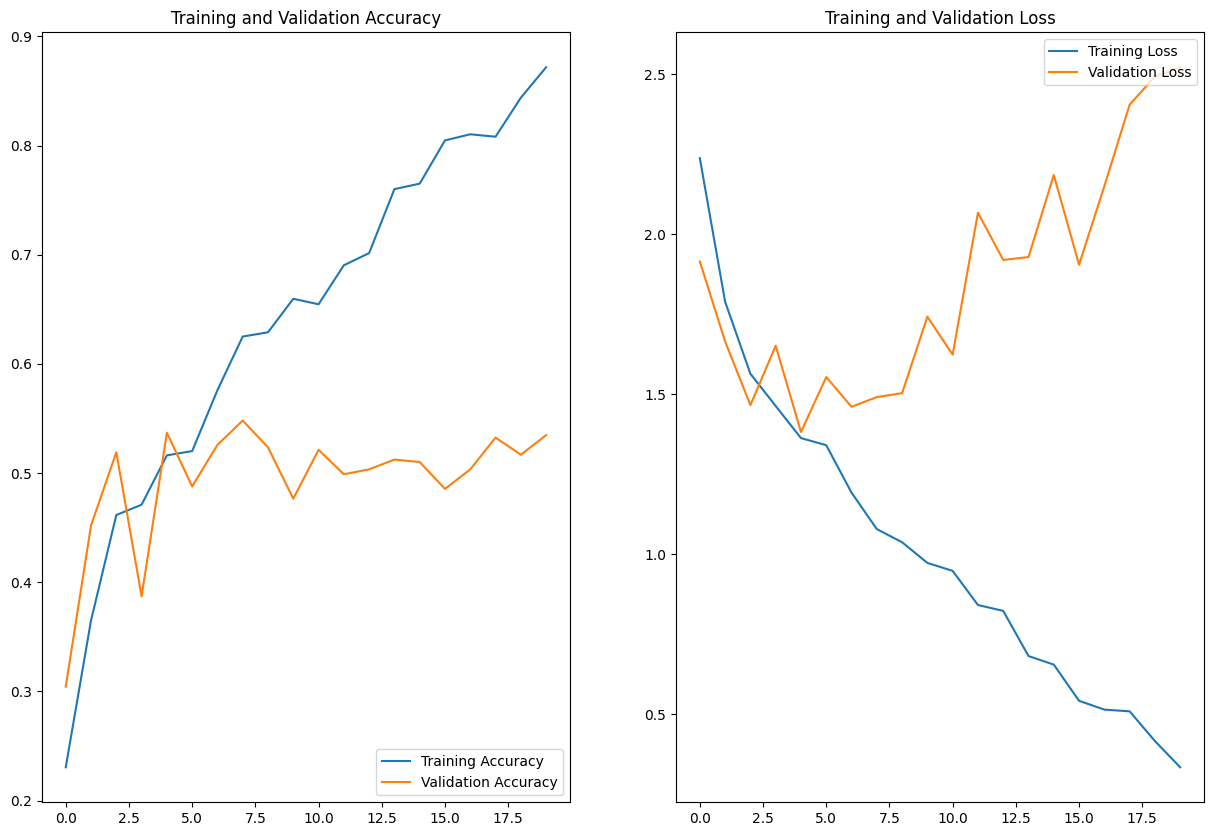

In [22]:
plot_training_history(history, 20)

In [23]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
data_augmentation.add(layers.RandomRotation(0.1))
data_augmentation.add(layers.RandomZoom(0.1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model = build_model(data_augmentation)

added augmentation


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 107584)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       6,885,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,909,609 (26.36 MB)

 Trainable params: 6,909,609 (26.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
%%time
history = model.fit(train_data, validation_data= validation_data, epochs=20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1831 - loss: 2.3815 - val_accuracy: 0.2953 - val_loss: 1.8459
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3396 - loss: 1.8200 - val_accuracy: 0.4206 - val_loss: 1.6403
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4184 - loss: 1.6247 - val_accuracy: 0.4564 - val_loss: 1.5892
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4499 - loss: 1.5421 - val_accuracy: 0.4631 - val_loss: 1.5290
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4770 - loss: 1.4983 - val_accuracy: 0.4362 - val_loss: 1.6314
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5133 - loss: 1.4680 - val_accuracy: 0.5034 - val_loss: 1.4338
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5233 - loss: 1.3956 - val_accuracy: 0.5011 - val_loss: 1.4053
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5165 - loss: 1.3717 - val_accuracy: 0.5123 - v

* <b>Overfitting addressed:</b> By leveraging data augmentation, overfitting has been effectively reduced.

* <b> Training and validation accuracy:</b> Both the training and validation accuracy are now within a similar range. Training accuracy reduced down from 85% to 64%

* <b>Underfitting observed:</b> Despite addressing overfitting, both training and validation performance are still poor, indicating the model is now underfitting.

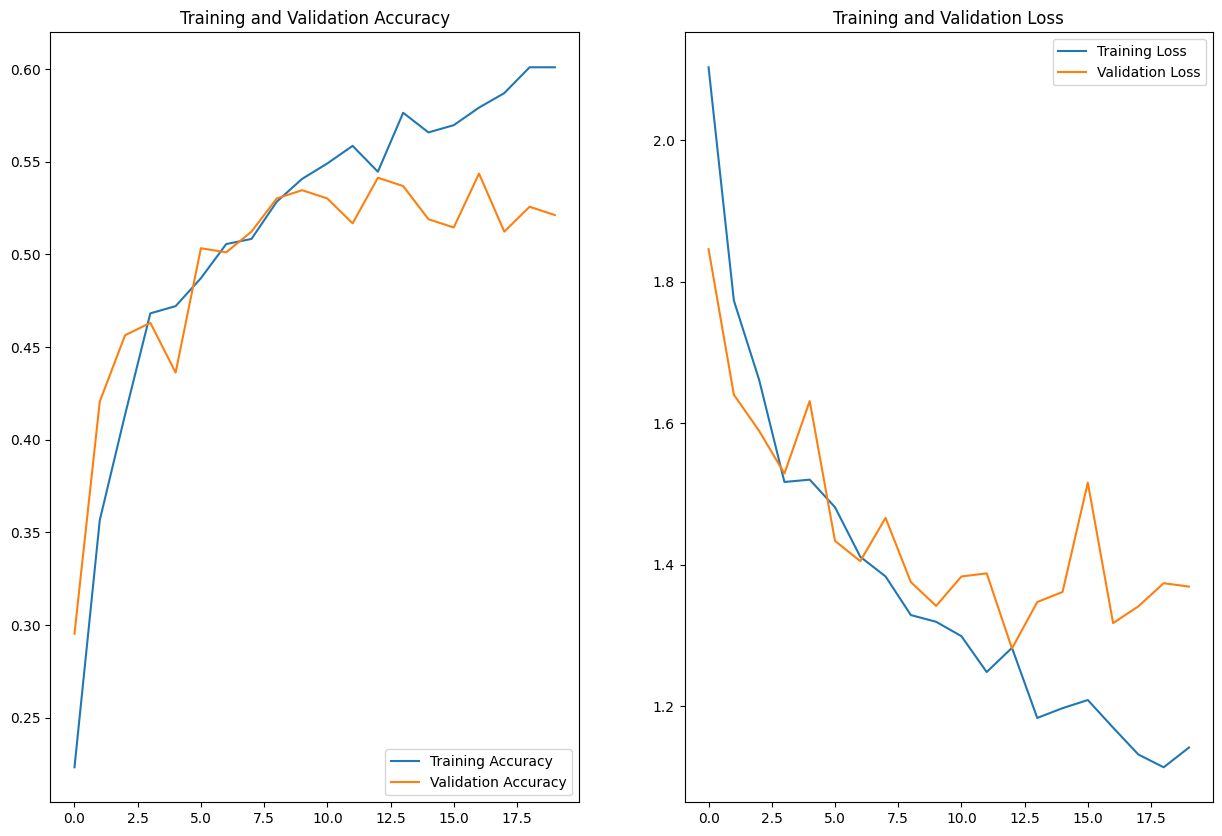

In [26]:
plot_training_history(history, 20)

In [27]:
# Verifying class distribution before applying augumentation
base_dir = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_df_count = count_files_in_class_subdirectories(base_dir)
train_df_count

,Class Name,File Count
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


<h4><b>Note: We need to use Augmentor library to make the same amount of images for each categories will resolve the problem of class inbalance. </h4>

In [28]:
!pip install Augmentor

In [29]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF1E1ED1900>: 100%|██████████| 500/500 [00:04<00:00, 105.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF1E1EB05E0>: 100%|██████████| 500/500 [00:04<00:00, 101.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF1807229B0>: 100%|██████████| 500/500 [00:04<00:00, 100.08 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DF1DE117070>: 100%|██████████| 500/500 [00:13<00:00, 35.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7DF180655BA0>: 100%|██████████| 500/500 [00:13<00:00, 37.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DF1806854B0>: 100%|██████████| 500/500 [00:04<00:00, 100.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DF1981E85E0>: 100%|██████████| 500/500 [00:07<00:00, 68.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF1981E9480>: 100%|██████████| 500/500 [00:05<00:00, 99.56 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF1CC11AEC0>: 100%|██████████| 500/500 [00:05<00:00, 99.80 Samples/s] 


In [30]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [31]:
import os
import shutil

for class_name in class_names:
  # Define the source and destination paths
  source = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+class_name+'/output/'
  destination = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/output/Train/'+class_name

  # Check if the source exists
  if os.path.exists(source):
      # Move the file or directory
      shutil.move(source, destination)
      print(f"Moved '{source}' to '{destination}'.")
  else:
      print(f"Source '{source}' does not exist.")




Moved '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/' to '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/output/Train/actinic keratosis'.
Moved '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/' to '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/output/Train/basal cell carcinoma'.
Moved '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/' to '/content/drive/Othe

In [32]:
#Verifying applying augmentation
base_dir = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/output/Train'
train_df_count = count_files_in_class_subdirectories(base_dir)
train_df_count

,Class Name,File Count
0,basal cell carcinoma,500
1,dermatofibroma,500
2,melanoma,500
3,nevus,500
4,pigmented benign keratosis,500
5,seborrheic keratosis,500
6,squamous cell carcinoma,500
7,vascular lesion,500
8,actinic keratosis,500


In [33]:
data_dir_train_aug = '/content/drive/Othercomputers/My PC/Upgrad/Case_Study/4_Melanoma_deep_learning/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/output/Train'

# data_dir_train="path to directory with training data + data created using augmentor"
train_data_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [34]:
validation_data_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [35]:
# Normalize pixel values to be between 0 and 1
normalization_layer = layers.Rescaling(1./255)
train_data_aug_bn = train_data_aug.map(lambda x, y: (normalization_layer(x), y))
validation_data_aug_bn = validation_data_aug.map(lambda x, y: (normalization_layer(x), y))

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_aug_bn = train_data_aug_bn.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data_aug_bn = validation_data_aug_bn.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense

model = models.Sequential()

model.add(data_augmentation)
model.add(Conv2D(16,(3,3), input_shape=(img_height,img_width,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(9,activation='softmax'))

model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 107584)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       6,885,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,909,609 (26.36 MB)

 Trainable params: 6,909,609 (26.36 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
%%time
history = model.fit(train_data_aug_bn, validation_data= validation_data_aug_bn, epochs=30)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.1180 - loss: 2.7213 - val_accuracy: 0.1600 - val_loss: 2.1398
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1515 - loss: 2.1506 - val_accuracy: 0.2189 - val_loss: 2.0936
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2151 - loss: 2.0714 - val_accuracy: 0.2433 - val_loss: 2.0001
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2697 - loss: 1.9157 - val_accuracy: 0.1378 - val_loss: 2.2310
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2047 - loss: 2.0671 - val_accuracy: 0.3378 - val_loss: 1.7562
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3540 - loss: 1.7272 - val_accuracy: 0.3811 - val_loss: 1.6054
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3881 - loss: 1.5741 - val_accuracy: 0.4189 - val_loss: 1.5089
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4439 - loss: 1.4633 - val_acc

In [39]:
results = model.evaluate(validation_data_aug_bn, batch_size=None, verbose=1, steps=None, return_dict=False)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7056 - loss: 0.8447


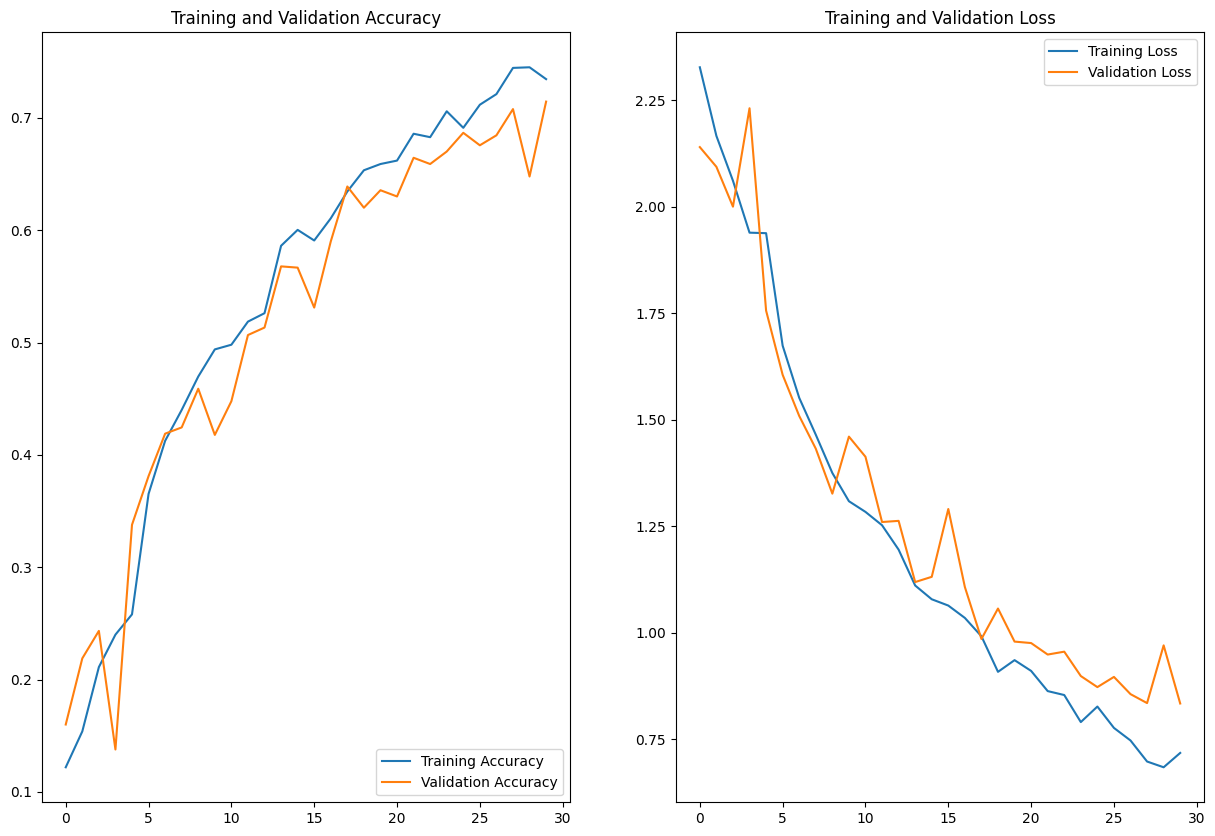

In [40]:
plot_training_history(history, 30)

* <b> Well-balanced performance:</b> The final model demonstrates a balanced performance, showing no signs of underfitting or overfitting.

* <b>  Class rebalancing:</b> The implementation of class rebalancing significantly improved the model's performance on both training and validation datasets.

* <b>  Model accuracy:</b> After 30 epochs, the model achieves 80% accuracy on the training set and approximately 77% on the validation set.

<h3><b>Model With more layers</b></h3>

In [46]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense

model = models.Sequential()

model.add(data_augmentation)
model.add(Conv2D(16,(3,3), input_shape=(img_height,img_width,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,(3,3), activation='relu'))
model.add(layers.Dropout(0.20))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(layers.Dropout(0.30))

model.add(Dense(256,activation='relu'))
model.add(layers.Dropout(0.20))

model.add(Dense(9,activation='softmax'))

model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,672,233 (14.01 MB)

 Trainable params: 3,672,233 (14.01 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
%%time
history = model.fit(train_data_aug_bn, validation_data= validation_data_aug_bn, epochs=10)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9047 - loss: 0.2345 - val_accuracy: 0.8311 - val_loss: 0.6655
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9133 - loss: 0.2400 - val_accuracy: 0.8722 - val_loss: 0.5770
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9112 - loss: 0.2239 - val_accuracy: 0.8778 - val_loss: 0.5105
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9097 - loss: 0.2483 - val_accuracy: 0.8656 - val_loss: 0.5351
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9281 - loss: 0.1852 - val_accuracy: 0.8800 - val_loss: 0.5277
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9197 - loss: 0.2152 - val_accuracy: 0.8767 - val_loss: 0.5375
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9136 - loss: 0.2255 - val_accuracy: 0.8644 - val_loss: 0.5635
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9050 - loss: 0.2584 - val_accu

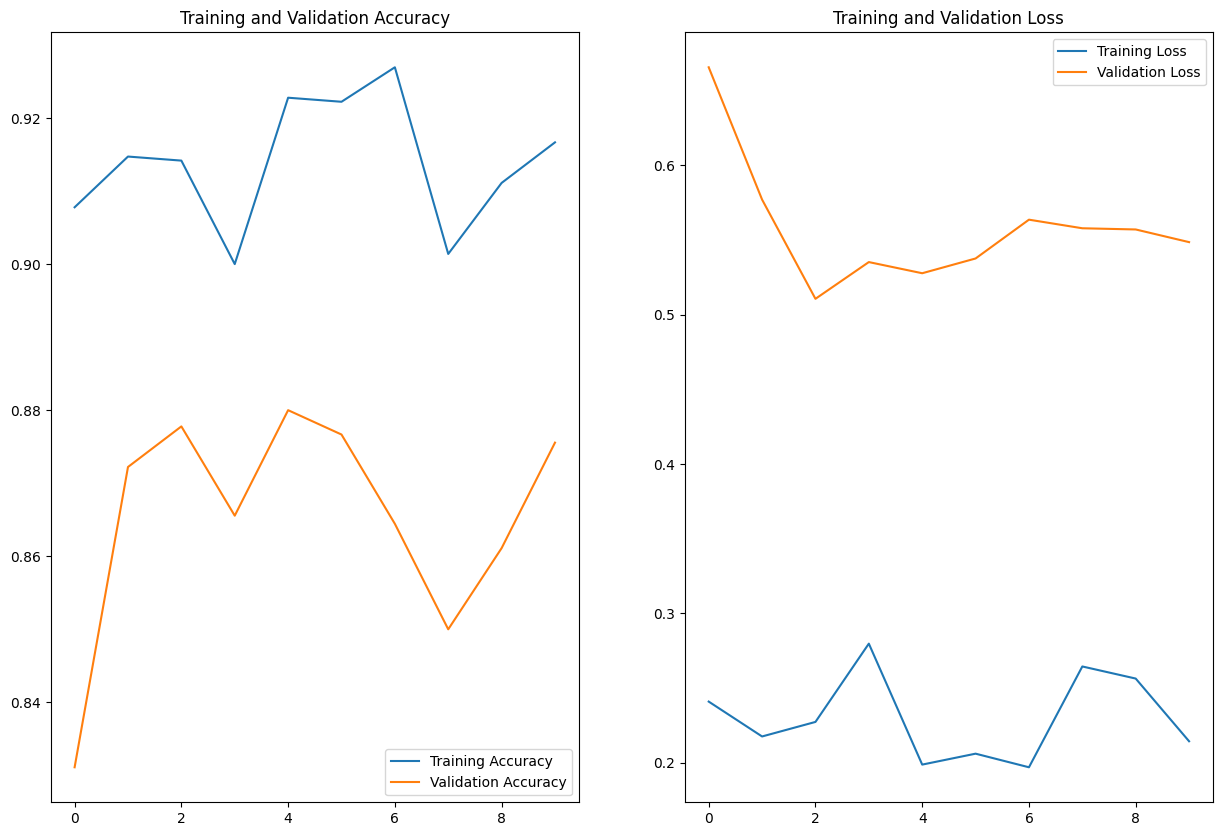

In [71]:
plot_training_history(history, 10)

<h3><b>Model Evaluation </b></h3>

In [72]:
results = model.evaluate(validation_data_aug_bn, batch_size=None, verbose=1, steps=None, return_dict=False)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8518 - loss: 0.6554


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


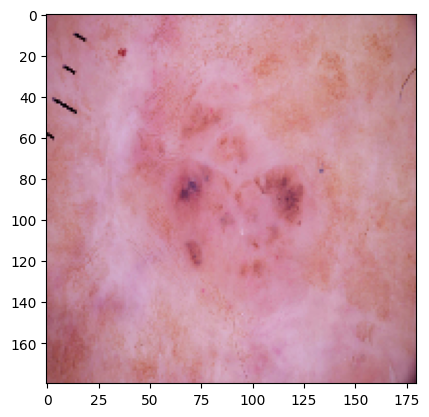

In [74]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img
from glob import glob

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1],target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)